Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Year = year(ymd_hms(IssuedDate))`.
Caused by warning:
! All formats failed to parse. No formats found.”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


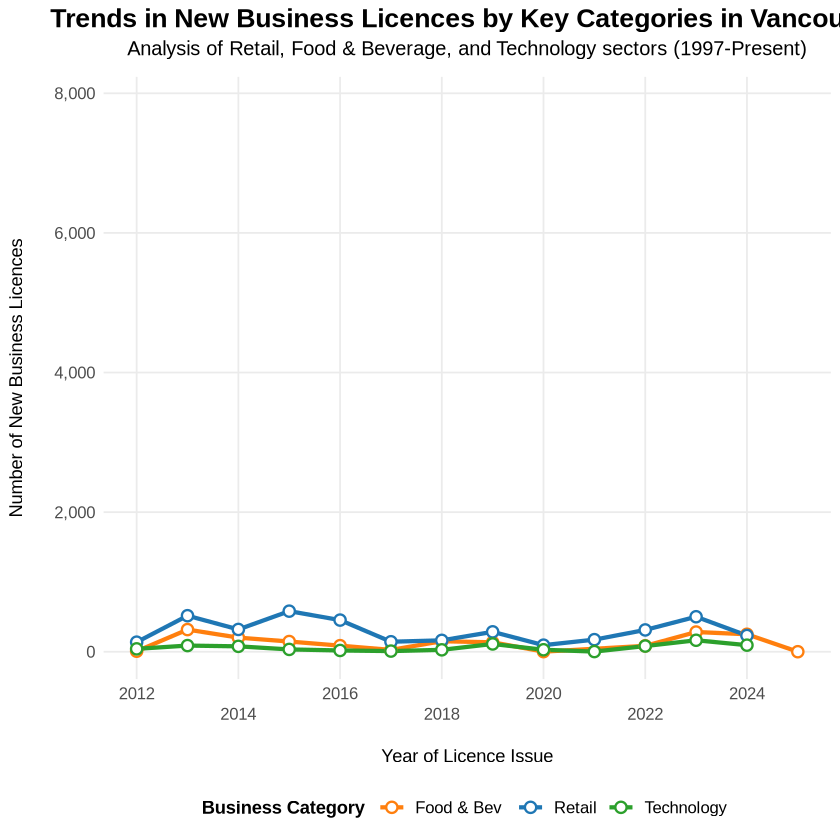

In [5]:

# 1. Load Libraries
library(dplyr)    # For data manipulation (e.g., mutate, group_by, summarise, filter, select, bind_rows)
library(ggplot2)  # For creating high-quality data visualizations
library(readr)    # For efficiently reading delimited data (e.g., CSV files)
library(lubridate) # For working with dates, specifically to extract the year from date strings

# 2. Data Loading
# Define URLs for the three different business licence datasets from Vancouver Open Data
url_current <- "business-licences.csv"
url_2013_2024 <- "business-licences-2013-to-2024.csv"
url_1997_2012 <- "business-licences-1997-to-2012.csv"

# Load each dataset directly from the URL.
# IMPORTANT: Use read_delim(url, delim=";") because OpendataSoft exports CSVs with semicolons.
# We also suppress column type messages for cleaner output.

# Load and standardize column names for the current business licences dataset
df_current <- read_delim(url_current, delim = ";", show_col_types = FALSE) %>%
  select(IssuedDate, BusinessType) %>%
  mutate(Year = year(ymd_hms(IssuedDate))) # Extract year from 'IssuedDate'

# Load and standardize column names for the 2013-2024 business licences dataset
df_2013_2024 <- read_delim(url_2013_2024, delim = ";", show_col_types = FALSE) %>%
  select(IssuedDate, BusinessType) %>%
  mutate(Year = year(ymd_hms(IssuedDate))) # Extract year from 'IssuedDate'

# Load and standardize column names for the 1997-2012 business licences dataset
# Note: This dataset might have 'BUSINESS_TYPE' instead of 'BUSINESS_DESCRIPTION'
df_1997_2012 <- read_delim(url_1997_2012, delim = ";", show_col_types = FALSE) %>%
  select(IssuedDate, BusinessType) %>%
  mutate(Year = year(ymd_hms(IssuedDate))) # Extract year from 'IssuedDate'

# Combine all datasets into a single dataframe.
# We select only the 'Year' and 'BusinessType' columns for consistency before binding.
combined_data <- bind_rows(
  df_current %>% select(Year, BusinessType),
  df_2013_2024 %>% select(Year, BusinessType),
  df_1997_2012 %>% select(Year, BusinessType)
)

# 3. Data Transformation (Crucial Step)

# Step 3: Categorize Business Types
# The raw data has granular types (e.g., "Retail Dealer", "Computer Services").
# We group them into 3 main buckets using regular expressions for a high-level trend analysis.
combined_data <- combined_data %>%
  mutate(Category = case_when(
    # "Retail": This category groups businesses primarily involved in selling goods directly to consumers.
    # It includes general retail, specialized dealers, and various types of shops or stores.
    # Examples: "Retail Dealer", "Gift Shop", "Clothing Store".
    grepl("Retail|Dealer|Shop|Store", BusinessType, ignore.case = TRUE) ~ "Retail",

    # "Food & Bev": This category encompasses establishments focused on food preparation,
    # service, and the sale of beverages, including alcoholic ones.
    # Examples: "Restaurant", "Cafe", "Pub", "Liquor Store", "Food Truck".
    grepl("Restaurant|Food|Cafe|Liquor|Pub", BusinessType, ignore.case = TRUE) ~ "Food & Bev",

    # "Technology": This category covers businesses in information technology, software development,
    # web services, IT consulting, and related tech fields.
    # Examples: "Computer Services", "Software Development", "Web Design", "IT Consultant".
    grepl("Computer|Software|Tech|Consultant|Web", BusinessType, ignore.case = TRUE) ~ "Technology",
    TRUE ~ "Other" # Any business type not matched by the above categories is grouped as "Other"
  )) %>%
  # Filter to only include the main categories we are interested in for the "trends" chart.
  filter(Category %in% c("Retail", "Food & Bev", "Technology"))

# Step 4: Aggregate by Year and Category
# This step calculates the number of business licences issued each year for each of our defined categories.
plot_data <- combined_data %>%
  group_by(Year, Category) %>%
  summarise(Count = n(), .groups = 'drop') # 'Count' is the number of licences; .groups = 'drop' removes grouping

# 4. Visualization
# Generate a production-ready line chart to visualize the trends of business licence counts
# over time for the selected categories (Retail, Food & Bev, Technology).
ggplot(plot_data, aes(x = Year, y = Count, color = Category)) +
  geom_line(linewidth = 1.2) + # Draw lines connecting data points, set a slightly thicker line for emphasis
  geom_point(size = 2.5, shape = 21, fill = "white", stroke = 1) + # Add points with white fill and border
  labs(
    title = "Trends in New Business Licences by Key Categories in Vancouver",
    subtitle = "Analysis of Retail, Food & Beverage, and Technology sectors (1997-Present)",
    x = "Year of Licence Issue",
    y = "Number of New Business Licences",
    color = "Business Category" # Title for the legend
  ) +
  scale_x_continuous(
    breaks = scales::pretty_breaks(n = 10), # Automatically generate nice breaks for the x-axis
    guide = guide_axis(n.dodge = 2) # Dodge x-axis labels if they overlap
  ) +
  scale_y_continuous(labels = scales::comma) + # Format y-axis labels with commas for readability
  scale_color_manual(values = c("Retail" = "#1f77b4", "Food & Bev" = "#ff7f0e", "Technology" = "#2ca02c")) + # Custom colors
  theme_minimal() + # Use a clean, minimalist theme from ggplot2
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16), # Center and bold plot title
    plot.subtitle = element_text(hjust = 0.5, size = 12, margin = margin(b = 10)), # Center subtitle with bottom margin
    axis.title.x = element_text(margin = margin(t = 15), size = 11), # Add top margin to x-axis title
    axis.title.y = element_text(margin = margin(r = 15), size = 11), # Add right margin to y-axis title
    axis.text = element_text(size = 10), # Adjust font size for axis labels
    legend.position = "bottom", # Place the legend at the bottom of the plot
    legend.title = element_text(face = "bold", size = 11), # Bold legend title
    legend.text = element_text(size = 10), # Adjust font size for legend text
    panel.grid.minor = element_blank() # Remove minor grid lines for a cleaner look
  )

# The generated plot object will be displayed if run in an R environment (e.g., RStudio).